###  Dependencies

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import csv
from fastprogress.fastprogress import master_bar, progress_bar
from pathlib import Path
from pebble import ProcessPool
from concurrent.futures import TimeoutError

# import musicautobot
from musicautobot.numpy_encode import *
from musicautobot.config import *
from musicautobot.music_transformer.dataloader import *
from musicautobot.music_transformer.transform import *

from fastai.basics import *
from fastai.text.learner import LanguageLearner, get_language_model, _model_meta
from fastai.text.models.transformer import TransformerXL
from fastai import basic_train # for predictions

---
### Paths

In [2]:
paths = {'midi_files': Path('data/midi'), # Location of the midi files
         'data_path': Path('data/numpy'), # Location to save the dataset
         'examples': Path('data/examples')} # Location of example midi files

data_save_name = 'musicitem_data_save.pkl'

# Checks
paths['midi_files'].mkdir(parents=True, exist_ok=True)
paths['data_path'].mkdir(parents=True, exist_ok=True)

In [3]:
from music21 import environment
musescore_path = r'C:\Program Files\MuseScore 3\bin\MuseScore3.exe'
environment.set('musicxmlPath', musescore_path)
environment.set('musescoreDirectPNGPath', musescore_path)

---

### Create the dataset
Create the dataset from the midi files using the pre-processing technique used by MusicAutobot

In [4]:
midi_files = get_files(paths['midi_files'], '.mid', recurse=True)
len(midi_files)

191

In [4]:
# Create MusicItems for each MIDI file
processors = [Midi2ItemProcessor()]
data = MusicDataBunch.from_files(midi_files, paths['data_path'], processors=processors, bs=2, bptt=12, ignore_empty=True)

# Save the data to a pickle to be utilized later
data.save(data_save_name)

C:\Users\Danny\miniconda3\envs\musicautobot\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


---
### Helper Functions

In [5]:
def rand_window_mask(x_len,m_len,device,max_size:int=None,p:float=0.2,is_eval:bool=False):
    if is_eval or np.random.rand() >= p or max_size is None: 
        win_size,k = (1,1)
    else: win_size,k = (np.random.randint(0,max_size)+1,0)
    return window_mask(x_len, device, m_len, size=(win_size,k))

In [6]:
def window_mask(x_len, device, m_len=0, size=(1,1)):
    win_size,k = size
    mem_mask = torch.zeros((x_len,m_len), device=device)
    tri_mask = torch.triu(torch.ones((x_len//win_size+1,x_len//win_size+1), device=device),diagonal=k)
    window_mask = tri_mask.repeat_interleave(win_size,dim=0).repeat_interleave(win_size,dim=1)[:x_len,:x_len]
    if x_len: window_mask[...,0] = 0 # Always allowing first index to see. Otherwise you'll get NaN loss
    mask = torch.cat((mem_mask, window_mask), dim=1)[None,None]
    return mask.bool() if hasattr(mask, 'bool') else mask.byte()

In [7]:
def is_empty_midi(fp):
    if fp is None: return False
    mf = file2mf(fp)
    return not any([t.hasNotes() for t in mf.tracks])

In [8]:
__all__ = ['top_k_top_p']

# top_k + nucleus filter - https://twitter.com/thom_wolf/status/1124263861727760384?lang=en
# https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317

def top_k_top_p(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
    """
    logits = logits.clone()
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

In [9]:
def process_all(func, arr, timeout_func=None, total=None, max_workers=None, timeout=None):
    with ProcessPool() as pool:
        future = pool.map(func, arr, timeout=timeout)

        iterator = future.result()
        results = []
        for i in progress_bar(range(len(arr)), total=len(arr)):
            try:
                result = next(iterator)
                if result: results.append(result)
            except StopIteration:
                break  
            except TimeoutError as error:
                if timeout_func: timeout_func(arr[i], error.args[1])
    return results

In [10]:
def process_file(file_path, tfm_func=None, src_path=None, dest_path=None):
    "Utility function that transforms midi file to numpy array."
    output_file = Path(str(file_path).replace(str(src_path), str(dest_path))).with_suffix('.npy')
    if output_file.exists(): return output_file
    output_file.parent.mkdir(parents=True, exist_ok=True)
    
    # Call tfm_func and save file
    npenc = tfm_func(file_path)
    if npenc is not None: 
        np.save(output_file, npenc)
        return output_file

---
### Model
Exactly like fastai's TransformerXL, but with a more aggressive attention mask:`rand_window_mask`

In [11]:
class MusicTransformerXL(TransformerXL):
    
    def __init__(self, *args, encode_position=True, mask_steps=1, **kwargs):
        import inspect
        sig = inspect.signature(TransformerXL)
        arg_params = { k:kwargs[k] for k in sig.parameters if k in kwargs }
        super().__init__(*args, **arg_params)

        self.encode_position = encode_position
        if self.encode_position: self.beat_enc = BeatPositionEncoder(kwargs['d_model'])
            
        self.mask_steps=mask_steps
        
        
    def forward(self, x):
        #The hidden state has to be initiliazed in the forward pass for nn.DataParallel
        if self.mem_len > 0 and not self.init: 
            self.reset()
            self.init = True

        benc = 0
        if self.encode_position:
            x,pos = x['x'], x['pos']
            benc = self.beat_enc(pos)

        bs,x_len = x.size()
        inp = self.drop_emb(self.encoder(x) + benc) #.mul_(self.d_model ** 0.5)
        m_len = self.hidden[0].size(1) if hasattr(self, 'hidden') and len(self.hidden[0].size()) > 1 else 0
        seq_len = m_len + x_len
        
        mask = rand_window_mask(x_len, m_len, inp.device, max_size=self.mask_steps, is_eval=not self.training) if self.mask else None
        if m_len == 0: mask[...,0,0] = 0
        #[None,:,:None] for einsum implementation of attention
        hids = []
        pos = torch.arange(seq_len-1, -1, -1, device=inp.device, dtype=inp.dtype)
        pos_enc = self.pos_enc(pos)
        hids.append(inp)
        for i, layer in enumerate(self.layers):
            mem = self.hidden[i] if self.mem_len > 0 else None
            inp = layer(inp, r=pos_enc, u=self.u, v=self.v, mask=mask, mem=mem)
            hids.append(inp)
        core_out = inp[:,-x_len:]
        if self.mem_len > 0 : self._update_mems(hids)
        return (self.hidden if self.mem_len > 0 else [core_out]),[core_out]


 # Beat encoder
class BeatPositionEncoder(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, emb_sz:int, beat_len=32, max_bar_len=1024):
        super().__init__()

        self.beat_len, self.max_bar_len = beat_len, max_bar_len
        self.beat_enc = nn.Embedding(beat_len, emb_sz, padding_idx=0)
        self.bar_enc = nn.Embedding(max_bar_len, emb_sz, padding_idx=0)
    
    def forward(self, pos):
        beat_enc = self.beat_enc(pos % self.beat_len)
        bar_pos = pos // self.beat_len % self.max_bar_len
        bar_pos[bar_pos >= self.max_bar_len] = self.max_bar_len - 1
        bar_enc = self.bar_enc((bar_pos))
        return beat_enc + bar_enc

### Learner
A LanguageLearner created using the TransformerXL Architecture and the data from the midi files 

In [12]:
_model_meta[MusicTransformerXL] = _model_meta[TransformerXL] # copy over fastai's model metadata

def music_model_learner(data:DataBunch, arch=MusicTransformerXL, config:dict=None, drop_mult:float=1.,
                        pretrained_path:PathOrStr=None, **learn_kwargs) -> 'LanguageLearner':
    "Create a `Learner` with a language model from `data` and `arch`."
    meta = _model_meta[arch]

    if pretrained_path: 
        state = torch.load(pretrained_path, map_location='cpu')
        if config is None: config = state['config']
        
    model = get_language_model(arch, len(data.vocab.itos), config=config, drop_mult=drop_mult)
    learn = MusicLearner(data, model, split_func=meta['split_lm'], **learn_kwargs)

    if pretrained_path: 
        get_model(model).load_state_dict(state['model'], strict=False)
        if not hasattr(learn, 'opt'): learn.create_opt(defaults.lr, learn.wd)
        try:    learn.opt.load_state_dict(state['opt'])
        except: pass
        del state
        gc.collect()

    return learn

# Predictions
class MusicLearner(LanguageLearner):
    def save(self, file:PathLikeOrBinaryStream=None, with_opt:bool=True, config=None):
        "Save model and optimizer state (if `with_opt`) with `file` to `self.model_dir`. `file` can be file-like (file or buffer)"
        out_path = super().save(file, return_path=True, with_opt=with_opt)
        if config and out_path:
            state = torch.load(out_path)
            state['config'] = config
            torch.save(state, out_path)
            del state
            gc.collect()
        return out_path

    def beam_search(self, xb:Tensor, n_words:int, top_k:int=10, beam_sz:int=10, temperature:float=1.,
                    ):
        "Return the `n_words` that come after `text` using beam search."
        self.model.reset()
        self.model.eval()
        xb_length = xb.shape[-1]
        if xb.shape[0] > 1: xb = xb[0][None]
        yb = torch.ones_like(xb)

        nodes = None
        xb = xb.repeat(top_k, 1)
        nodes = xb.clone()
        scores = xb.new_zeros(1).float()
        with torch.no_grad():
            for k in progress_bar(range(n_words), leave=False):
                out = F.log_softmax(self.model(xb)[0][:,-1], dim=-1)
                values, indices = out.topk(top_k, dim=-1)
                scores = (-values + scores[:,None]).view(-1)
                indices_idx = torch.arange(0,nodes.size(0))[:,None].expand(nodes.size(0), top_k).contiguous().view(-1)
                sort_idx = scores.argsort()[:beam_sz]
                scores = scores[sort_idx]
                nodes = torch.cat([nodes[:,None].expand(nodes.size(0),top_k,nodes.size(1)),
                                indices[:,:,None].expand(nodes.size(0),top_k,1),], dim=2)
                nodes = nodes.view(-1, nodes.size(2))[sort_idx]
                self.model[0].select_hidden(indices_idx[sort_idx])
                xb = nodes[:,-1][:,None]
        if temperature != 1.: scores.div_(temperature)
        node_idx = torch.multinomial(torch.exp(-scores), 1).item()
        return [i.item() for i in nodes[node_idx][xb_length:] ]

    def predict(self, item:MusicItem, n_words:int=128,
                     temperatures:float=(1.0,1.0), min_bars=4,
                     top_k=30, top_p=0.6):
        "Return the `n_words` that come after `text`."
        self.model.reset()
        new_idx = []
        vocab = self.data.vocab
        x, pos = item.to_tensor(), item.get_pos_tensor()
        last_pos = pos[-1] if len(pos) else 0
        y = torch.tensor([0])

        start_pos = last_pos

        sep_count = 0
        bar_len = SAMPLE_FREQ * 4 # assuming 4/4 time
        vocab = self.data.vocab

        repeat_count = 0
        if hasattr(self.model[0], 'encode_position'):
            encode_position = self.model[0].encode_position
        else: encode_position = False

        for i in progress_bar(range(n_words), leave=True):
            with torch.no_grad():
                if encode_position:
                    batch = { 'x': x[None], 'pos': pos[None] }
                    logits = self.model(batch)[0][-1][-1]
                else:
                    logits = self.model(x[None])[0][-1][-1]

            prev_idx = new_idx[-1] if len(new_idx) else vocab.pad_idx

            # Temperature
            # Use first temperatures value if last prediction was duration
            temperature = temperatures[0] if vocab.is_duration_or_pad(prev_idx) else temperatures[1]
            repeat_penalty = max(0, np.log((repeat_count+1)/4)/5) * temperature
            temperature += repeat_penalty
            if temperature != 1.: logits = logits / temperature
                

            # Filter
            # bar = 16 beats
            filter_value = -float('Inf')
            if ((last_pos - start_pos) // 16) <= min_bars: logits[vocab.bos_idx] = filter_value

            logits = filter_invalid_indexes(logits, prev_idx, vocab, filter_value=filter_value)
            logits = top_k_top_p(logits, top_k=top_k, top_p=top_p, filter_value=filter_value)
            
            # Sample
            probs = F.softmax(logits, dim=-1)
            idx = torch.multinomial(probs, 1).item()

            # Update repeat count
            num_choices = len(probs.nonzero().view(-1))
            if num_choices <= 2: repeat_count += 1
            else: repeat_count = repeat_count // 2

            if prev_idx==vocab.sep_idx: 
                duration = idx - vocab.dur_range[0]
                last_pos = last_pos + duration

                bars_pred = (last_pos - start_pos) // 16
                abs_bar = last_pos // 16
                # if (bars % 8 == 0) and (bars_pred > min_bars): break
                if (i / n_words > 0.80) and (abs_bar % 4 == 0): break


            if idx==vocab.bos_idx: 
                print('Predicted BOS token. Returning prediction...')
                break

            new_idx.append(idx)
            x = x.new_tensor([idx])
            pos = pos.new_tensor([last_pos])

        pred = vocab.to_music_item(np.array(new_idx))
        full = item.append(pred)
        return pred, full
    
# High level prediction functions from midi file
def predict_from_midi(learn, midi=None, n_words=400, 
                      temperatures=(1.0,1.0), top_k=30, top_p=0.6, seed_len=None, **kwargs):
    vocab = learn.data.vocab
    seed = MusicItem.from_file(midi, vocab) if not is_empty_midi(midi) else MusicItem.empty(vocab)
    if seed_len is not None: seed = seed.trim_to_beat(seed_len)

    pred, full = learn.predict(seed, n_words=n_words, temperatures=temperatures, top_k=top_k, top_p=top_p, **kwargs)
    return full

def filter_invalid_indexes(res, prev_idx, vocab, filter_value=-float('Inf')):
    if vocab.is_duration_or_pad(prev_idx):
        res[list(range(*vocab.dur_range))] = filter_value
    else:
        res[list(range(*vocab.note_range))] = filter_value
    return res

### Create a Language Learner Model

In [14]:
batch_size = 1
encode_position = True
dl_tfms = [batch_position_tfm] if encode_position else []
data = load_data(paths['data_path'], data_save_name, bs=batch_size, encode_position=encode_position, dl_tfms=dl_tfms)

In [15]:
config = default_config()
config['encode_position'] = encode_position
learn = music_model_learner(data, config=config.copy())

### Train the Model

In [16]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,2.713388,3.891418,0.150965,05:18
1,2.946846,3.497019,0.169112,05:51
2,3.112904,3.299683,0.150965,05:32
3,3.222362,3.111803,0.218147,05:17


In [17]:
# Save the model
learn.save('angry_model_1')

WindowsPath('data/numpy/models/angry_model_1.pth')

---
### Generate Music

#### Load the saved model

In [13]:
# Data
# data = MusicDataBunch.empty(paths['data_path'])
# vocab = data.vocab
data = load_data(paths['data_path'], 'musicitem_data_save.pkl')

# Load the model
pretrained_path = f"{paths['data_path']}/models/MusicTransformerKeyC.pth"
# pretrained_path = f"{paths['data_path']}/models/angry_model_1.pth"

# Learner
learn = music_model_learner(data, pretrained_path=pretrained_path)

#### Prediction
Choose existing midi file as a starting point

In [26]:
# midi_file = Path('data/examples/angry.mid'); midi_file
# midi_file = Path('data/examples/happy.mid'); midi_file
# midi_file = Path('data/examples/sad.mid'); midi_file
midi_file = Path('data/examples/neutral.mid'); midi_file

WindowsPath('data/examples/neutral.mid')

NextWord / Autocomplete  
Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [27]:
cutoff_beat = 10

item = MusicItem.from_file(midi_file, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

Original song clip

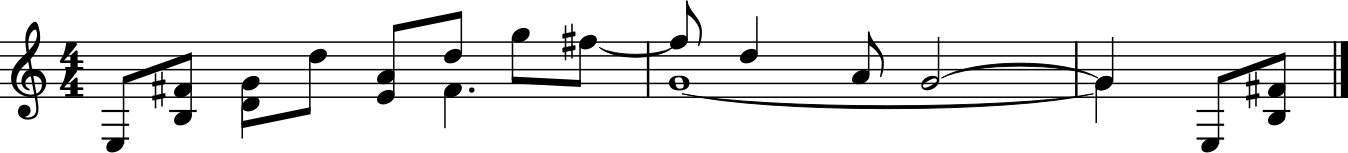

In [28]:
seed_item.show()

In [29]:
seed_item.play()

Predict next notes

In [30]:
pred, full = learn.predict(seed_item, n_words=400, temperatures=(1.1,0.4), min_bars=12, top_k=24, top_p=0.7)

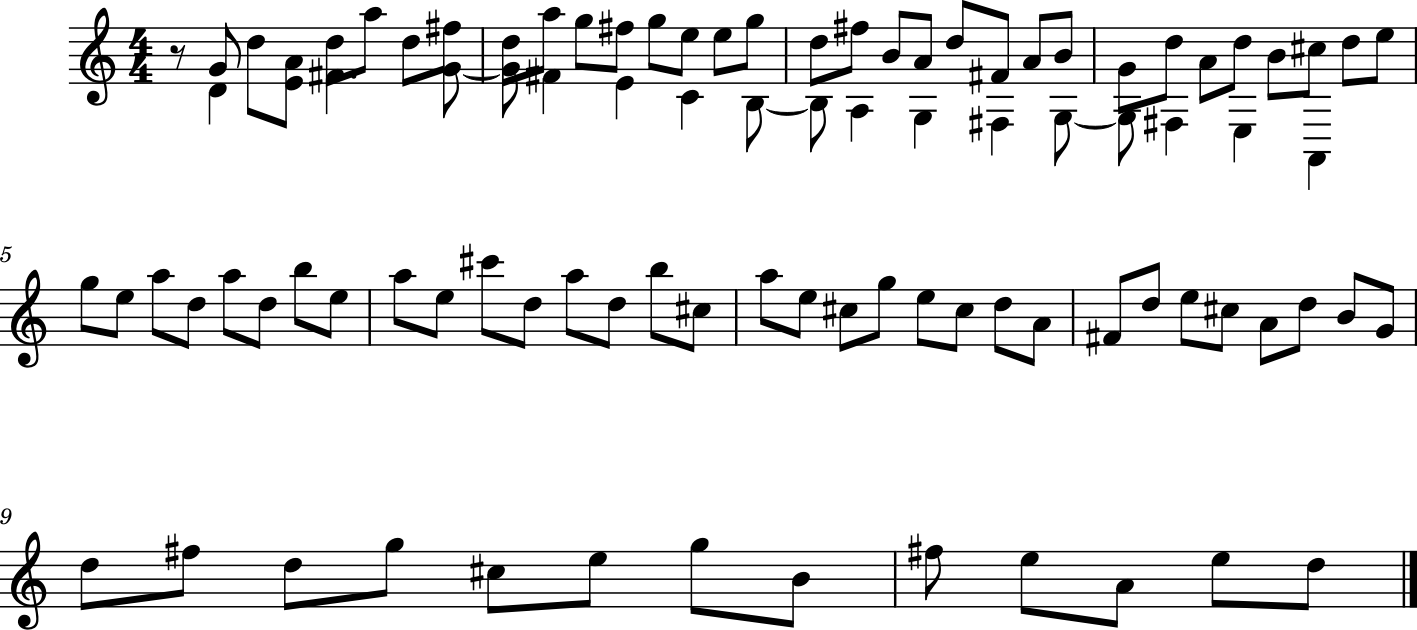

In [31]:
pred.show()

In [32]:
pred.play()

Full song -> original clip + prediction

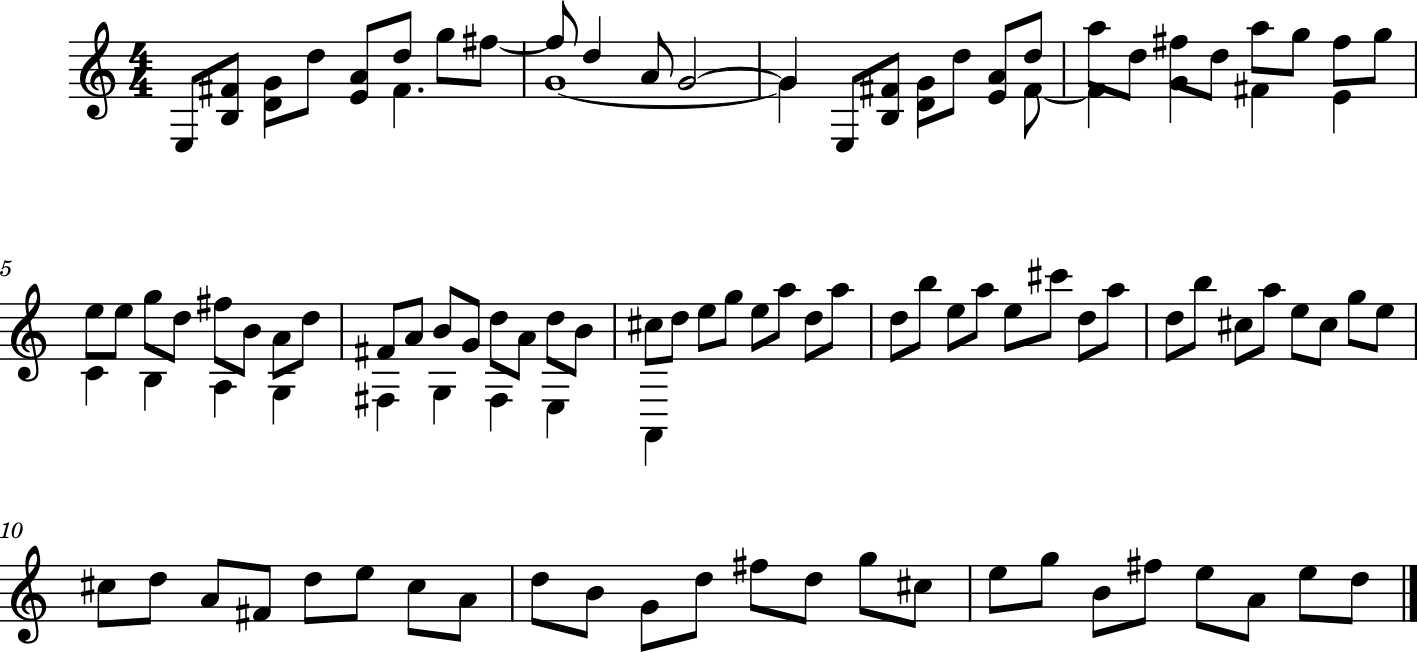

In [33]:
full_song = seed_item.append(pred)
full_song.show()

In [34]:
full_song.play()

In [98]:
output = full_song.to_stream()
fp = output.write('midi', fp='data/examples/sad_test.mid')